<a href="https://colab.research.google.com/github/dmnk1308/DubAir/blob/main/images_tfrec_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#from image_helpers_tfr import *
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/DubAir')
from image_helpers_tfr import *

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the listings and extract the price

In [4]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
urls = listings["listing_url"]
ids = listings["id"]
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
price = pd.DataFrame(price)
price["log_price"] = np.log(price)
price["id"] = listings["id"]
price = price[["id", "price", "log_price"]]

Set the path to the downloaded and resized images

In [5]:
folder_images = "data/images_resized"
#folder_tfrecord= "data/tfrecord_id"
folder_tfrecord= "/content/drive/Othercomputers/Mein MacBook Air/tfrecord_id"
#img_path = os.listdir(folder_images)

Set up a dataframe which contains the listing id the number of the image for the id and its corresponding path alongside with the log-price

In [ ]:
# separate id and image number
df = pd.Series(img_path).str.split("_", expand = True)
df.columns = ["listing_id", "img_no"]
listing_id = df["listing_id"]

df = df["img_no"].str.split(".", expand = True)
df.columns = ["img_no", "png"]
image_no = df["img_no"]

# build dataframe with id, img number and path to the image
data = pd.DataFrame({"id": listing_id, "img_no": image_no, "path": img_path})



NameError: ignored

In [ ]:
# join prices 
price["id"] = price["id"].astype(int)
data["id"] = data["id"].astype(int)
df_compl = data.merge(price, how = "left", on = "id")
df_compl["id"] = df_compl["id"].astype(str)

Next, write tf-record files which contain the images and prices for each id

In [8]:
df_compl = pd.read_csv("/content/drive/MyDrive/DubAir/df_compl.csv")

In [9]:
unique_ids = np.unique(df_compl["id"])

In [ ]:
for id in tqdm(unique_ids):
    filter = df_compl["id"] == id
    data_to_write = df_compl[filter]
    # for computational reasons, only take first picture
    data_to_write = data_to_write[data_to_write["img_no"]=="0"]
    filename = folder_tfrecord +"/"+ id
    write_features(data_to_write["id"].values, data_to_write["path"].values, data_to_write["log_price"].values, path = folder_images+"/", filename = filename)


Split data in training, test and validation ids, store corresponding tf-record data and create datasets

In [42]:
X_train, X_test = train_test_split(unique_ids, test_size=0.2, random_state=1)

X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
X_train = [folder_tfrecord + "/" + f + ".tfr" for f in X_train.astype(str)]
X_test = [folder_tfrecord + "/" + f + ".tfr" for f in X_test.astype(str)]
X_val = [folder_tfrecord + "/" + f + ".tfr" for f in X_val.astype(str)]

In [12]:
train_dataset = make_dataset(X_train, batch_size = 128)
test_dataset = make_dataset(X_test, batch_size = 128)
val_dataset = make_dataset(X_val, batch_size = 128)

In [11]:
basemodel = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', pooling = "avg", input_tensor = tf.keras.layers.Input(shape = (256, 256, 3), name = "input_1")
)
basemodel.trainable = False

outputs = tf.keras.layers.Dense(100, activation = "relu")(basemodel.output)
outputs = tf.keras.layers.Dense(1)(outputs)

model = tf.keras.Model(basemodel.input, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
              loss=tf.keras.losses.MeanSquaredError())
model.fit(train_dataset, epochs = 5)

16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
399/399 [==============================] - 3497s 9s/step - loss: 2.4468
Epoch 2/5
399/399 [==============================] - 3475s 9s/step - loss: 0.9550
Epoch 3/5
399/399 [==============================] - 3535s 9s/step - loss: 0.8251
Epoch 4/5
399/399 [==============================] - 3561s 9s/step - loss: 0.7639
Epoch 5/5
399/399 [==============================] - 3565s 9s/step - loss: 0.7196


In [12]:
model.save("/content/drive/MyDrive/DubAir/img_embeddings/tf_airbnb/model_all_img_100dense")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DubAir/img_embeddings/tf_airbnb/model_all_img_100dense/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [6]:
model = keras.models.load_model("/content/drive/MyDrive/DubAir/img_embeddings/tf_airbnb/model_all_img_100dense")

In [13]:
y_pred = model.predict(test_dataset)

In [29]:
img_test = np.concatenate([x["input_1"] for x, y in test_dataset], axis=0)

In [14]:
y_test = np.concatenate([y for x, y in test_dataset], axis=0)

In [17]:
y_pred = np.concatenate([y for y in y_pred], axis=0)

In [44]:
predict_df = pd.DataFrame({"id": X_test, "true": y_test, "pred": y_pred, "delta": y_test - y_pred})

ValueError: ignored

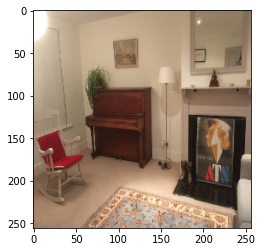

In [33]:
plt.imshow(X_test[471])

In [30]:
predict_df[np.abs(predict_df["delta"]) < 0.01]

,true,pred,delta
471,5.293305,5.292776,0.000529
574,5.068904,5.073664,-0.004759
603,5.393628,5.395905,-0.002277
734,5.616771,5.608322,0.008449
742,5.616771,5.614621,0.002151
...,...,...,...
17546,5.062595,5.062604,-0.000010
17560,5.062595,5.067941,-0.005346
17714,4.158883,4.149549,0.009334
17738,5.356586,5.349328,0.007258


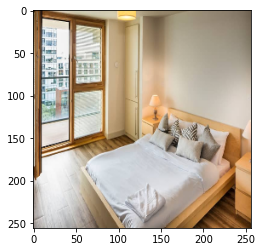

In [41]:
plt.imshow(X_test[16908])

In [25]:
predict_df.sort_values(by = "delta")

,true,pred,delta
16907,2.197225,5.426757,-3.229532
15335,2.197225,5.424827,-3.227602
16908,2.197225,5.368980,-3.171755
15331,2.197225,5.367746,-3.170521
15334,2.197225,5.357030,-3.159806
...,...,...,...
11593,8.379539,3.632000,4.747540
11595,8.379539,3.139648,5.239892
11603,8.379539,3.126188,5.253352
6308,5.192957,-0.218329,5.411285


In [27]:
predict_df["delta"].std()

0.8462112545967102

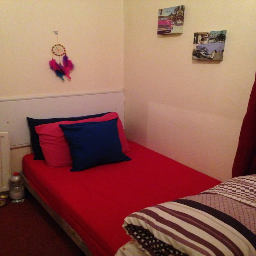

In [13]:
model_builder = model

preprocess_input = keras.applications.efficientnet.preprocess_input

last_conv_layer_name = "top_conv"

# The local path to our target image"
img_path = "/content/drive/MyDrive/DubAir/img_embeddings/tf_airbnb/images_resized/11572186_0.png"

display(Image(img_path))

In [26]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


[[4.5967207]]


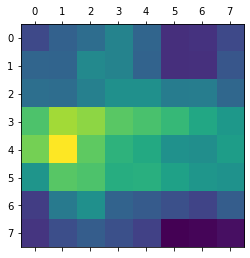

In [15]:
img_size = (256,256)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [25]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

NameError: ignored

# Make collage of first 5 pictures

In [ ]:
df_compl["img_no"].astype(int)

0        12
1         6
2        21
3         0
4        13
         ..
86440     6
86441    10
86442     6
86443     6
86444     5
Name: img_no, Length: 86445, dtype: int64

In [ ]:
df_collage = df_compl[df_compl["img_no"].astype(int)<=8]
df_unique = df_collage[["id", "log_price"]]
df_unique = df_unique.drop_duplicates()
unique_ids = df_unique["id"].astype(str)
unique_price = df_unique["log_price"]
img_stacked = []


Save collage images

In [ ]:
for id in tqdm(unique_ids):
    filter = df_collage["id"] == id
    paths = df_collage["path"][filter]
    img_tmp = []
    print(paths)
    for p in paths:
        img_tmp.append(cv2.imread("data/images_resized/"+p))

    img_tmp = np.hstack(img_tmp)
    cv2.imwrite("data/image_collage/"+id+".png", img_tmp)




Create train, test, val data from collages

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_unique["id"].values, df_unique["log_price"].values, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

Write tfr-files for each of the sets

In [ ]:
write_features(X_train, X_train+".png", y_train, path = "data/image_collage/", filename = "data/tfrecord_collage/train_collage")

write_features(X_val, X_val+".png", y_val, path = "data/image_collage/", filename = "data/tfrecord_collage/val_collage")

write_features(X_test, X_test+".png", y_test, path = "data/image_collage/", filename = "data/tfrecord_collage/test_collage")

100%|██████████| 1263/1263 [02:54<00:00,  7.24it/s]


1263

In [ ]:
val_dataset = make_dataset("data/tfrecord_id/44077.tfr", batch_size = 1).batch(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
train_dataset = make_dataset("data/tfrecord_collage/train_collage.tfr", batch_size = 1).batch(1)
test_dataset = make_dataset("data/tfrecord_collage/test_collage.tfr", batch_size = 1).batch(1)
val_dataset = make_dataset("data/tfrecord_collage/val_collage.tfr", batch_size = 1).batch(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [ ]:
inputs = tf.keras.layers.Input(shape = (None, None, 3), name = "input_1")
inputs = keras.applications.efficientnet.preprocess_input(inputs)
basemodel = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', pooling = "avg", input_tensor = inputs)
basemodel.trainable = False

outputs = tf.keras.layers.Flatten()(basemodel.output)
outputs = tf.keras.layers.Dense(200, activation = "relu")(outputs)
outputs = tf.keras.layers.Dense(1000, activation = "relu")(outputs)

outputs = tf.keras.layers.Dense(1)(outputs)


model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss="mean_squared_error", metrics=["mean_squared_error"])
model.fit(test_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1263/1263 [==============================] - 455s 358ms/step - loss: 3.9079 - mean_squared_error: 3.9079


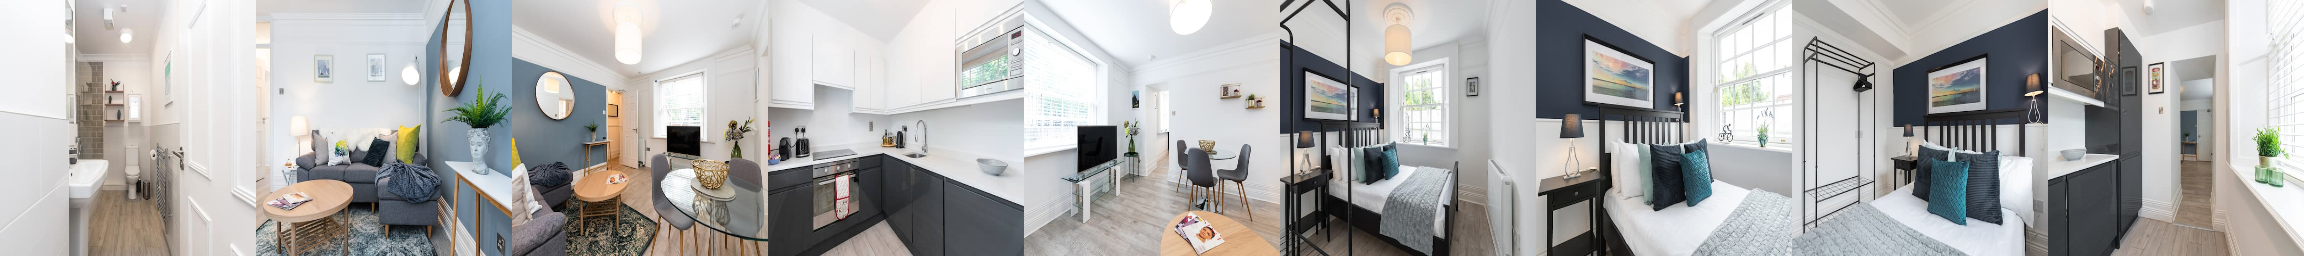

In [ ]:
model_builder = model

preprocess_input = keras.applications.efficientnet.preprocess_input

last_conv_layer_name = "top_conv"

# The local path to our target image"
img_path = "data/image_collage/53140691.png"

display(Image(img_path))

In [ ]:
w, h, d = cv2.imread(img_path).shape

[[2.2547915]]


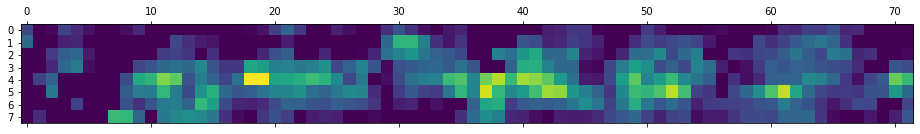

In [ ]:

img_size = (w,h)
img_array = get_img_array(preprocess_input(img_path), size=img_size)
# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
#model.layers[-2].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

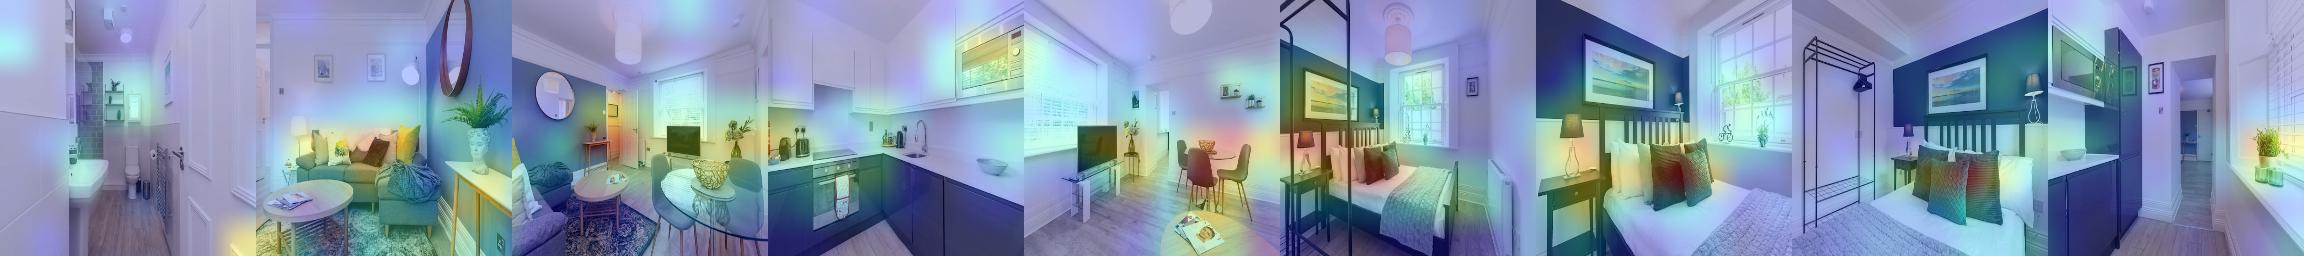

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# Train model for collage data 

In [5]:
folder_tfrecord= "/content/drive/Othercomputers/Mein MacBook Air/tfrecord_collage/"

In [9]:
train_dataset = make_dataset(folder_tfrecord + "train_collage.tfr", batch_size = 32)
test_dataset = make_dataset(folder_tfrecord + "test_collage.tfr", batch_size = 32)
val_dataset = make_dataset(folder_tfrecord + "val_collage.tfr", batch_size = 32)

In [ ]:
inputs = tf.keras.layers.Input(shape = (None, None, 3), name = "input_1")
#inputs = keras.applications.efficientnet.preprocess_input(inputs)
basemodel = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', pooling = "avg", input_tensor = inputs)
basemodel.trainable = False

outputs = tf.keras.layers.Flatten()(basemodel.output)
outputs = tf.keras.layers.Dense(500, activation = "relu")(outputs)
outputs = tf.keras.layers.Dense(1)(outputs)


model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss="mean_squared_error", metrics=["mean_squared_error"])
model.fit(train_dataset, epochs = 10)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
      2/Unknown - 29s 11s/step - loss: 17.2891 - mean_squared_error: 17.2891

In [ ]:
model.save("/content/drive/MyDrive/DubAir/img_embeddings/tf_airbnb/model_collage")

In [57]:
for i in test_dataset.take(1):
  img_arrays = i[0]["input_1"]
  prices = i[1]

In [52]:
model_builder = model
preprocess_input = keras.applications.efficientnet.preprocess_input
last_conv_layer_name = "top_conv"
b, w, h, d = img_arrays.shape

Predicted:  90.477455
True:  50.0


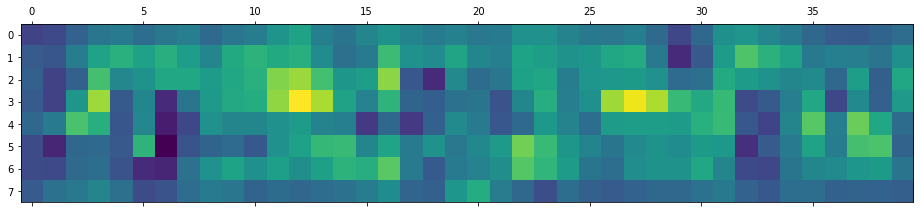

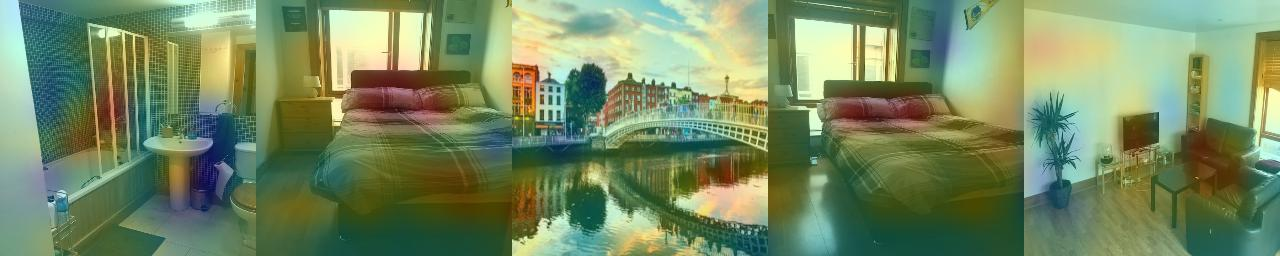

Predicted:  55.986958
True:  65.000015


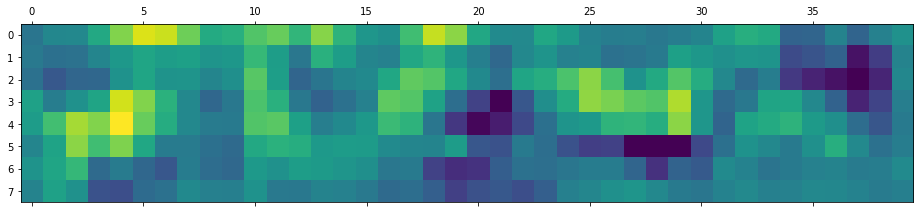

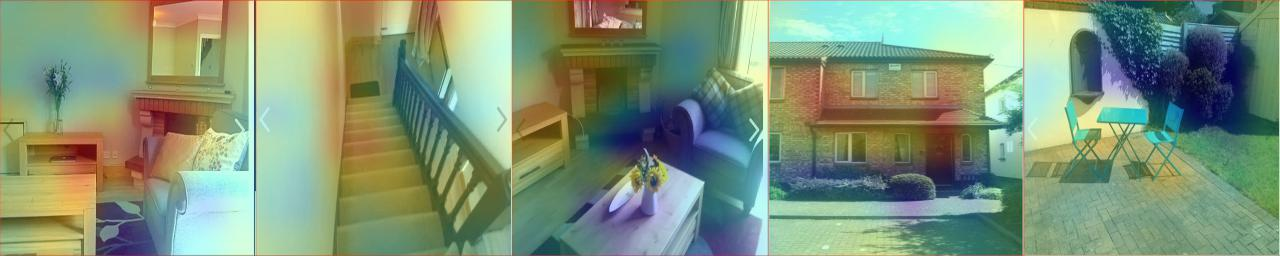

Predicted:  100.6638
True:  200.0


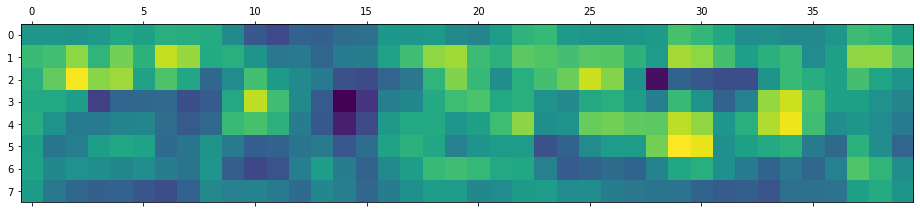

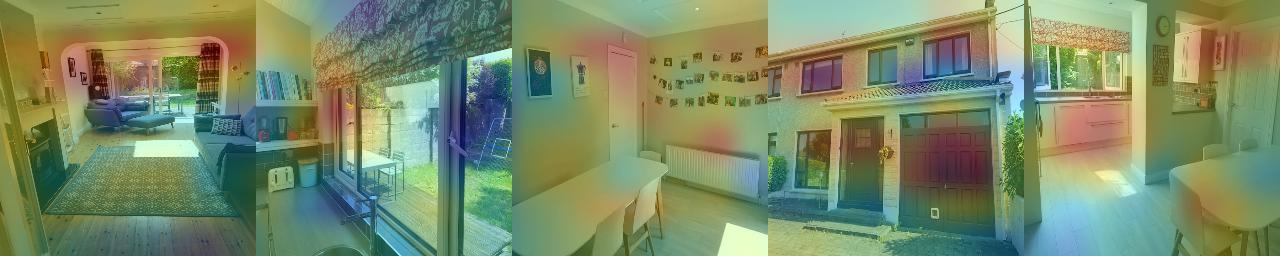

Predicted:  202.74689
True:  282.00006


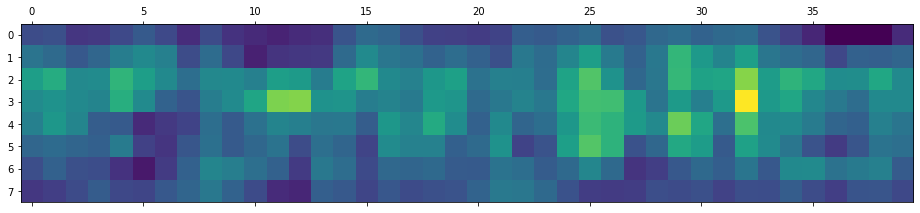

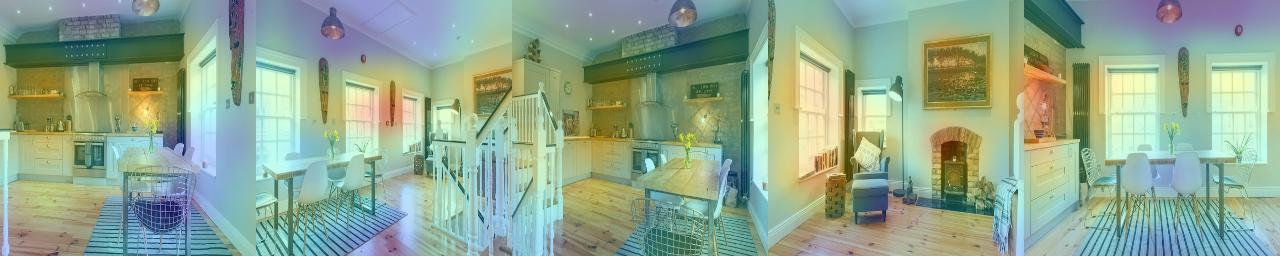

Predicted:  79.03906
True:  46.999992


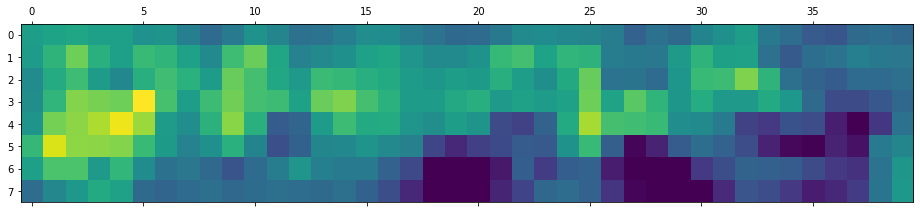

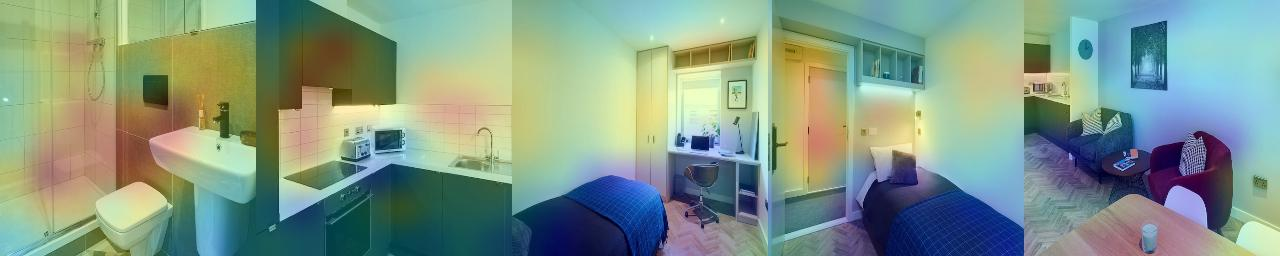

Predicted:  57.573284
True:  72.0


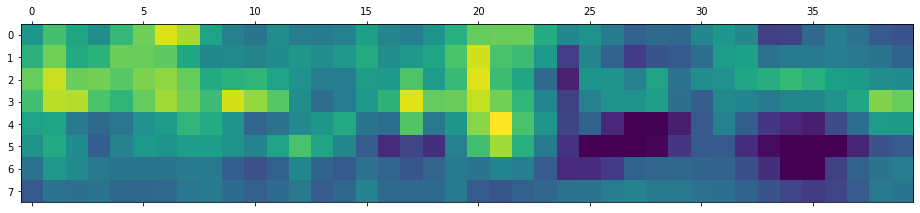

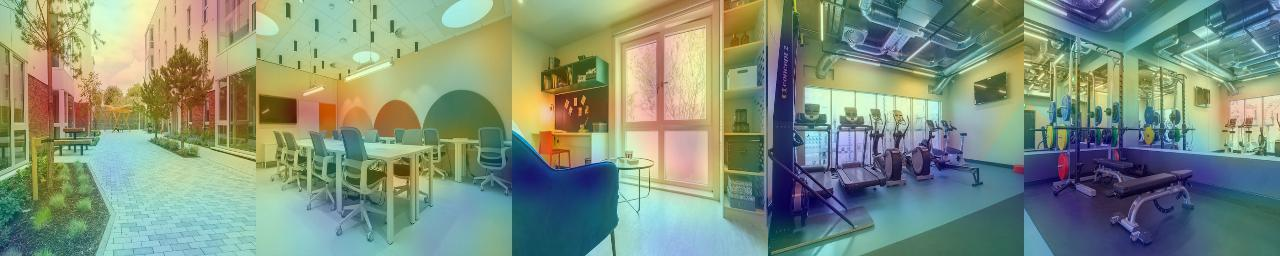

Predicted:  43.356045
True:  65.000015


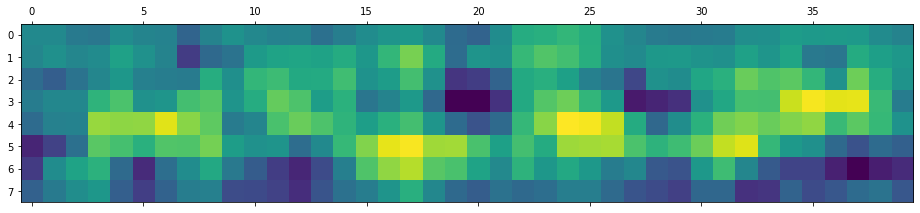

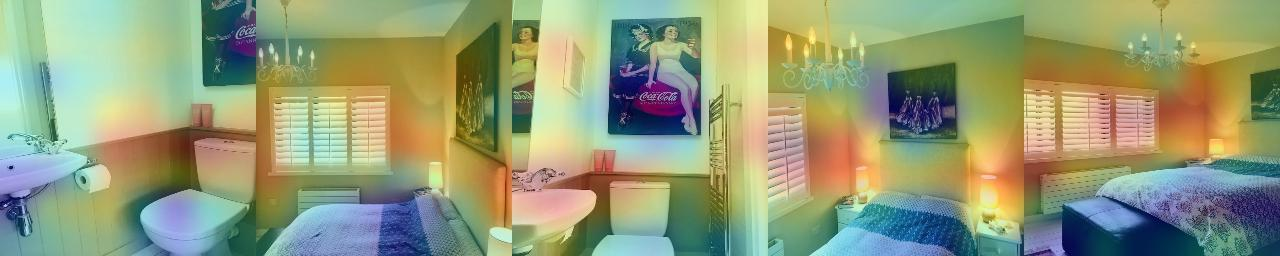

Predicted:  56.893715
True:  83.99999


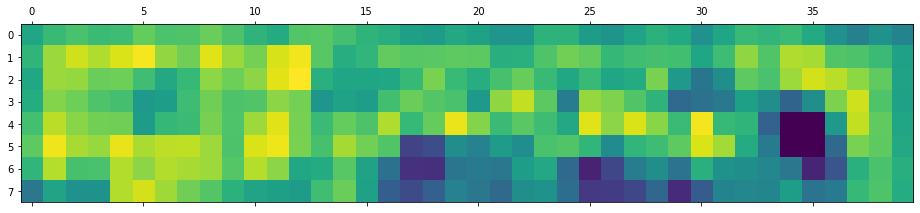

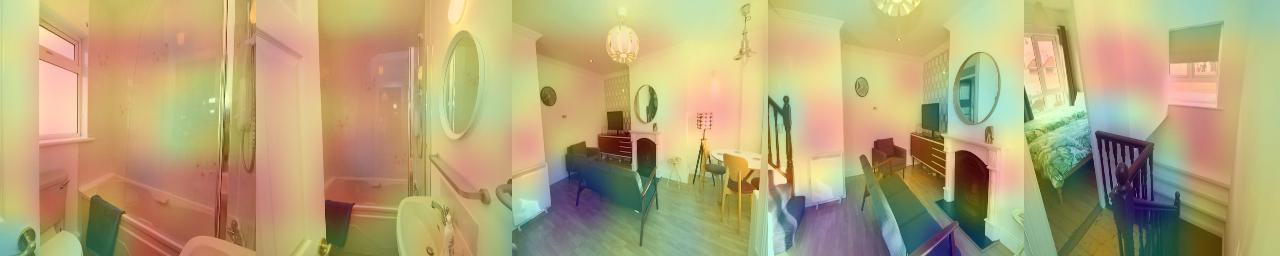

Predicted:  168.6444
True:  100.0


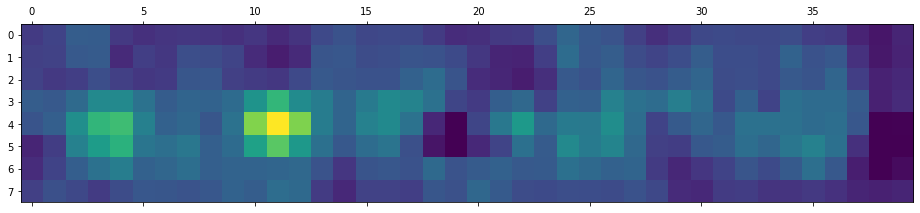

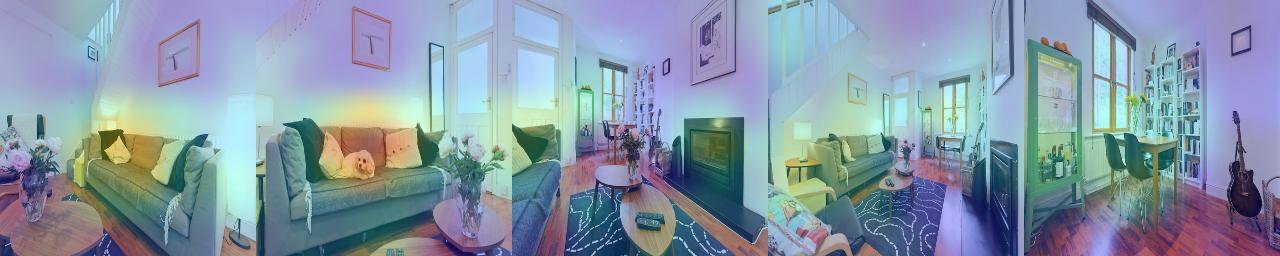

Predicted:  75.37154
True:  69.99999


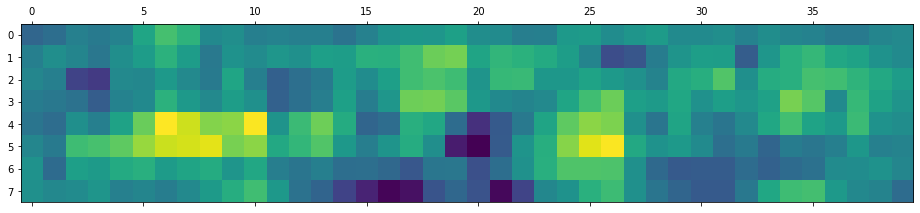

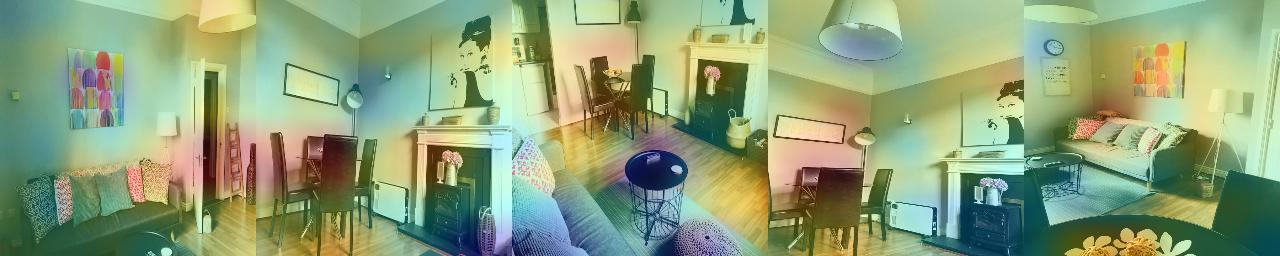

Predicted:  92.048355
True:  400.0


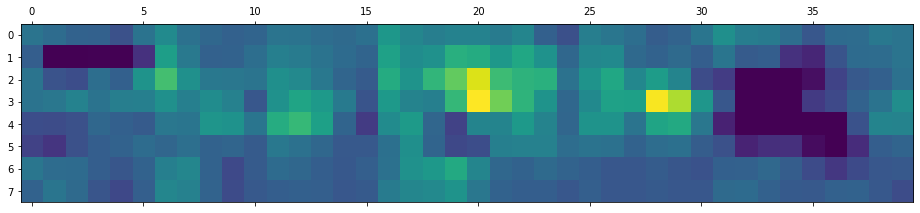

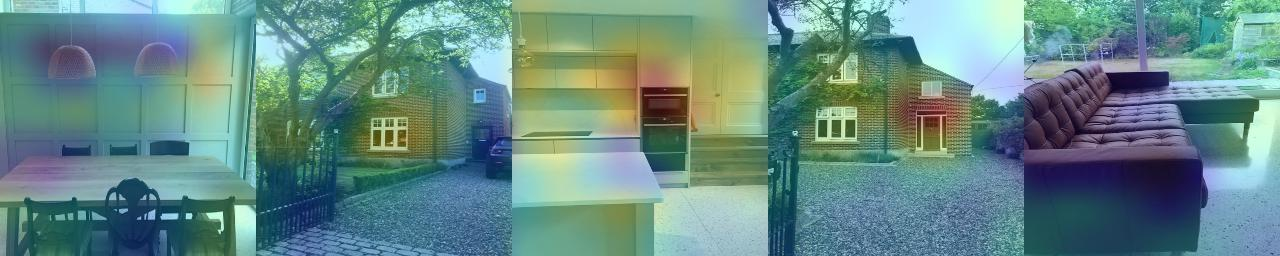

Predicted:  70.037994
True:  71.000015


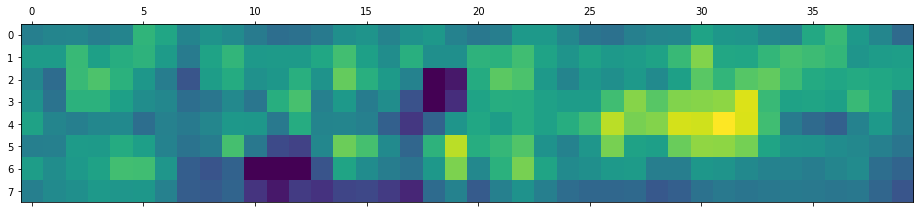

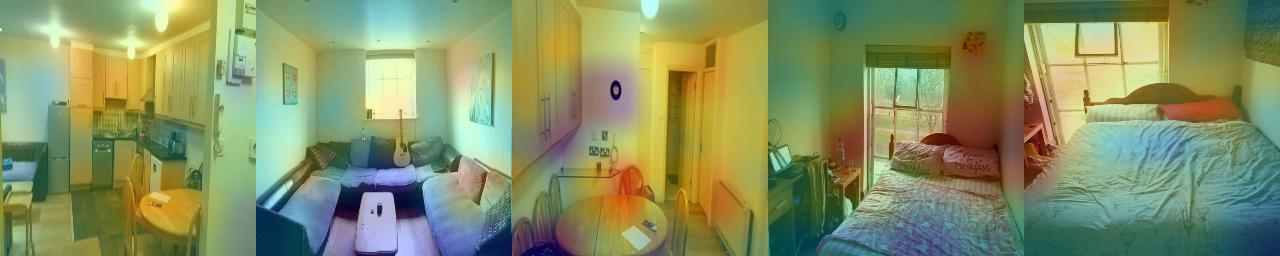

Predicted:  141.19075
True:  295.00003


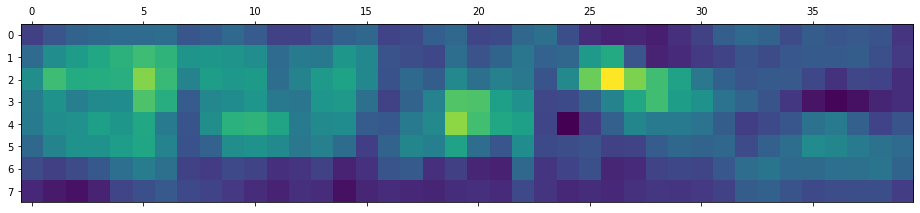

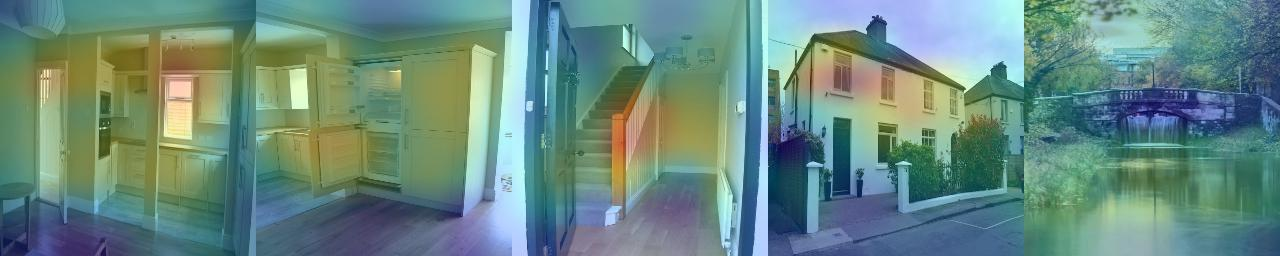

Predicted:  149.66592
True:  170.00002


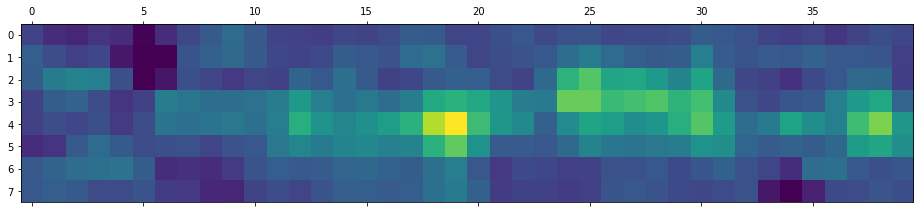

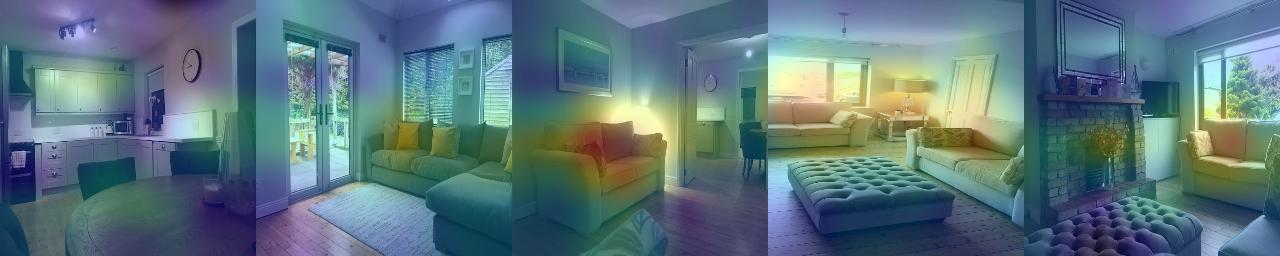

Predicted:  105.68272
True:  100.0


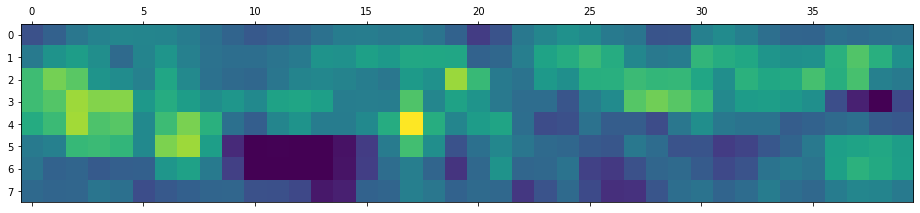

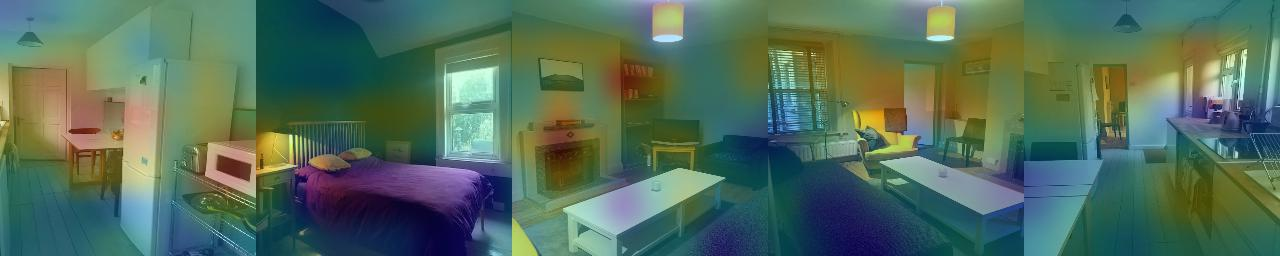

Predicted:  192.10669
True:  150.0


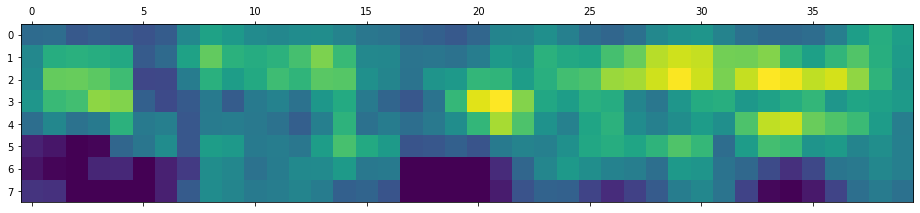

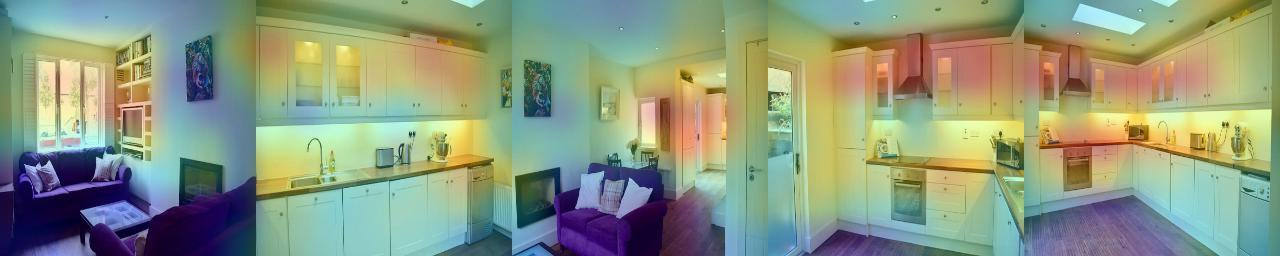

Predicted:  83.22426
True:  80.00001


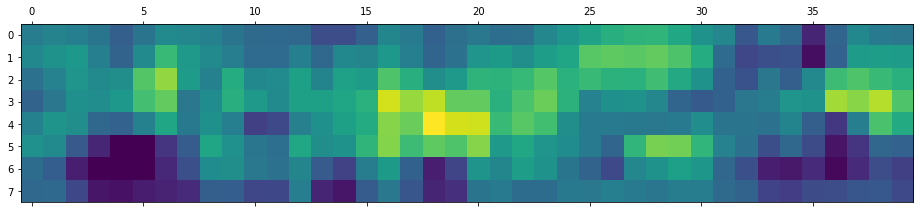

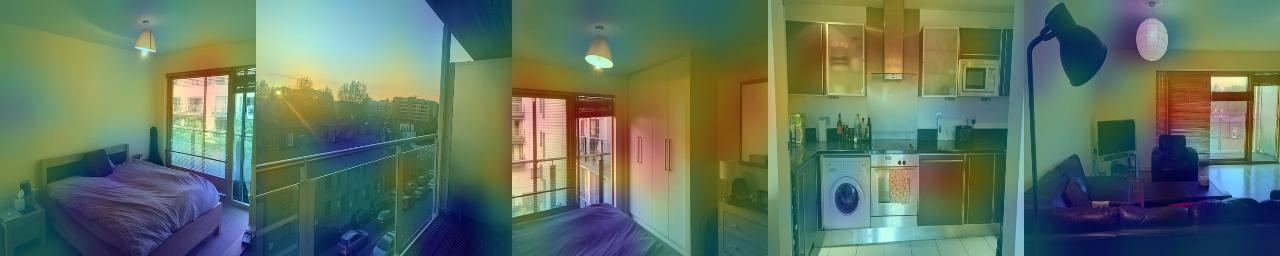

Predicted:  88.62091
True:  80.00001


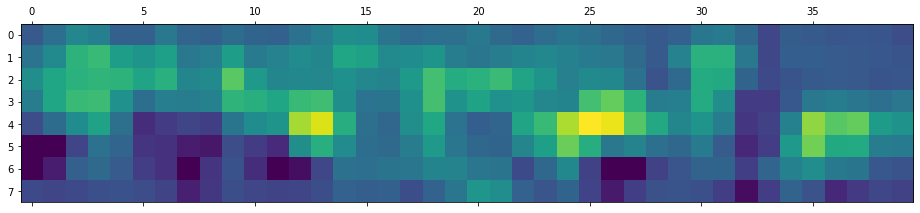

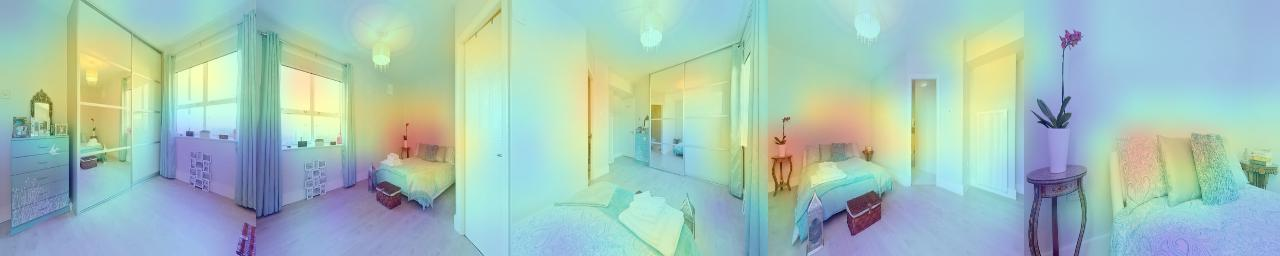

Predicted:  181.22813
True:  69.99999


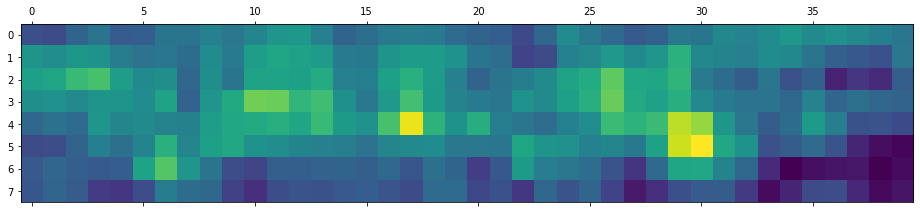

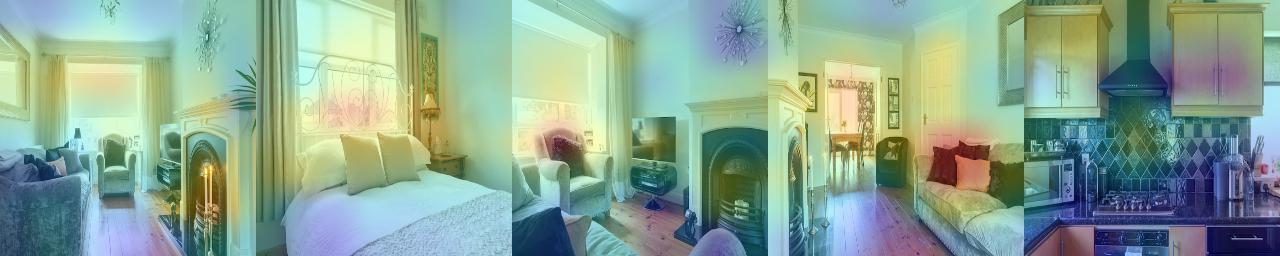

Predicted:  107.691826
True:  136.0


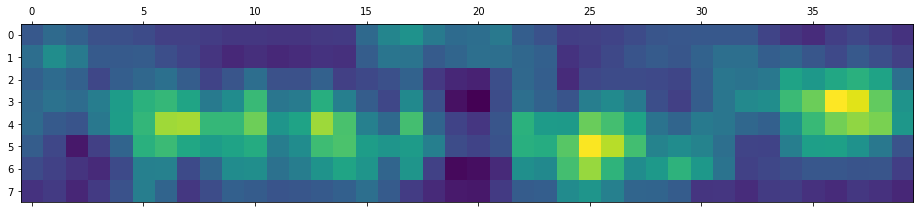

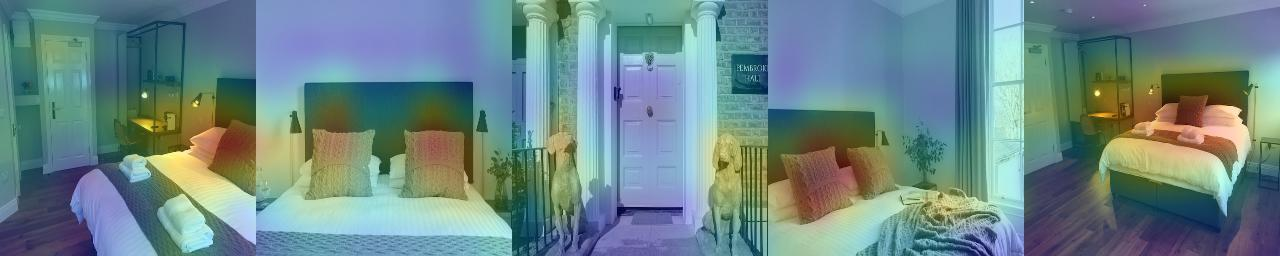

Predicted:  86.73857
True:  529.00006


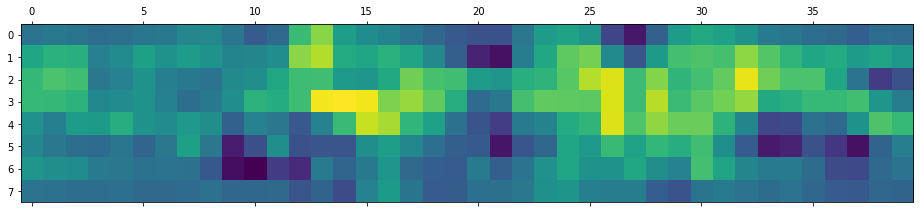

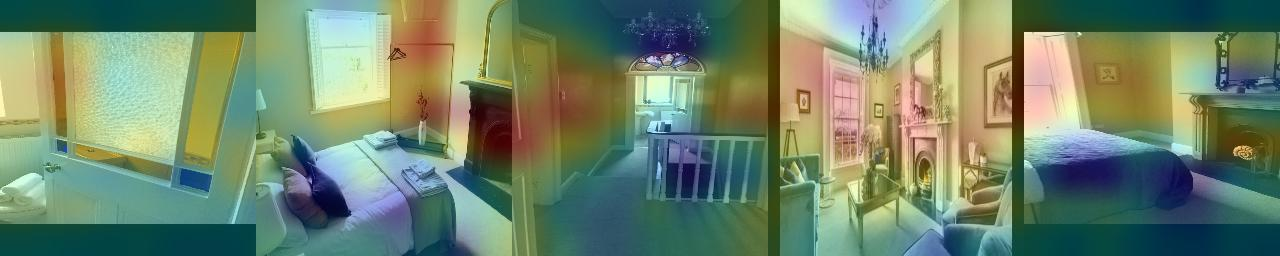

Predicted:  76.15943
True:  200.0


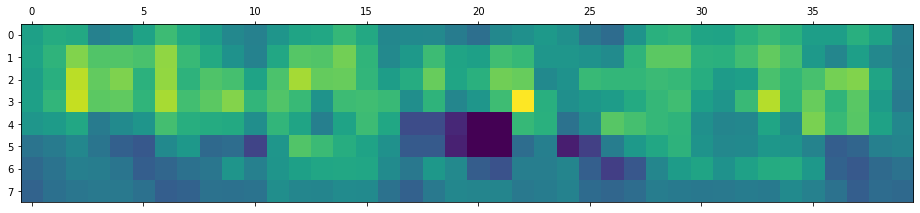

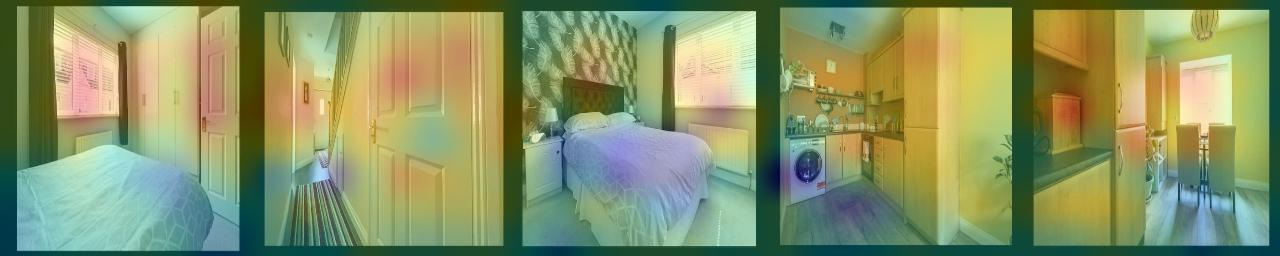

Predicted:  786.08777
True:  1570.0001


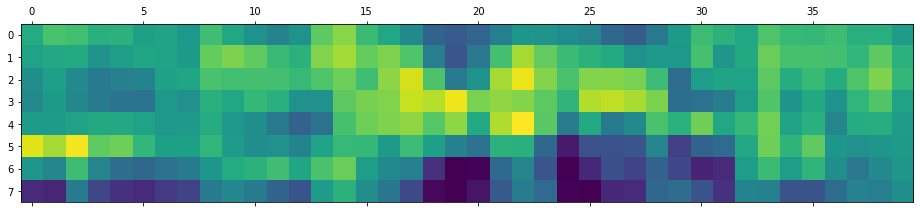

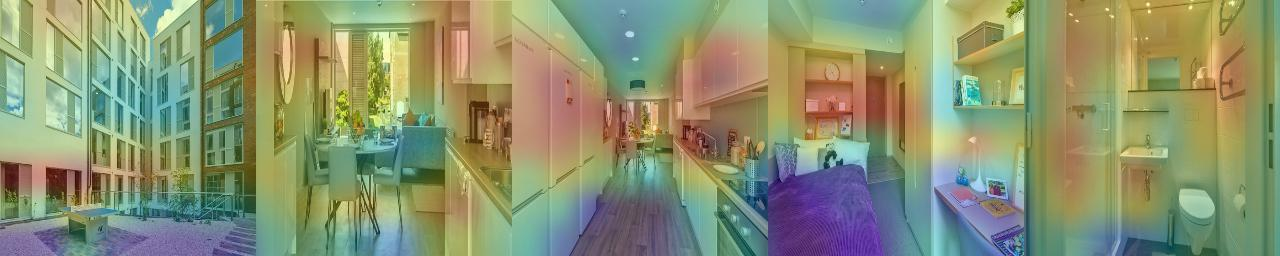

Predicted:  112.283226
True:  75.0


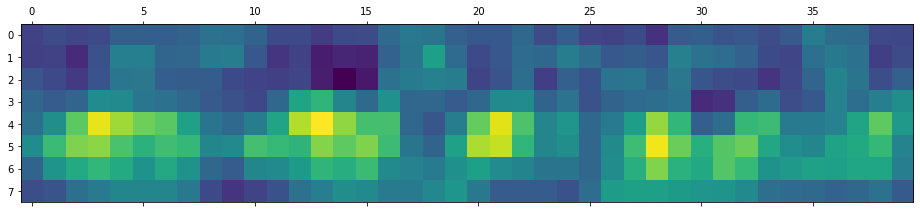

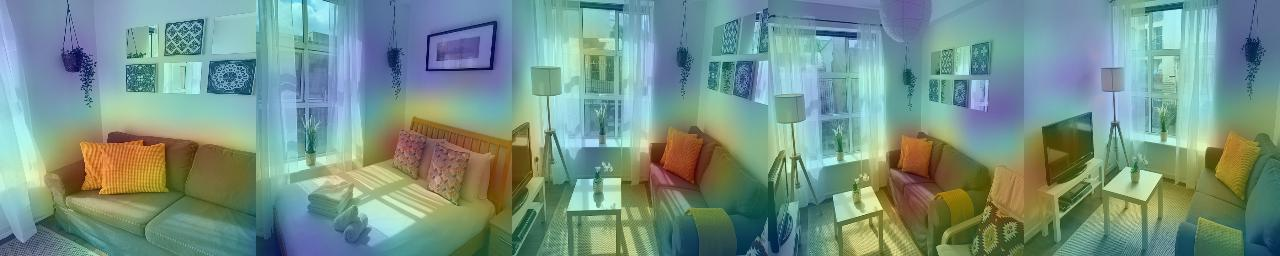

Predicted:  104.29505
True:  90.99999


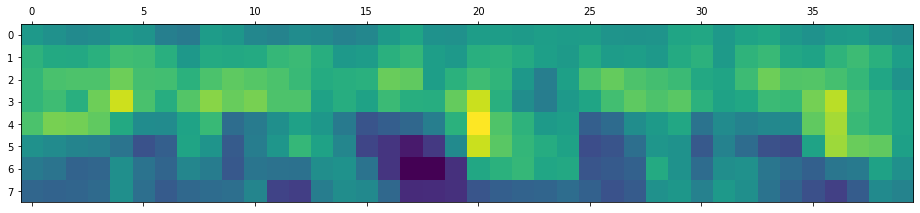

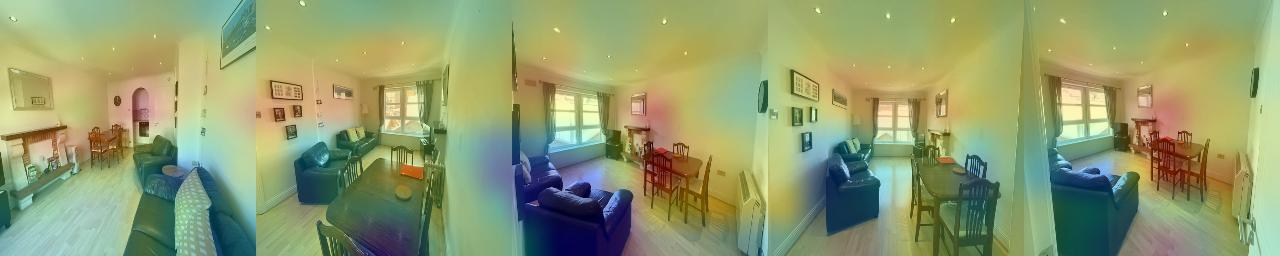

Predicted:  106.236984
True:  48.999992


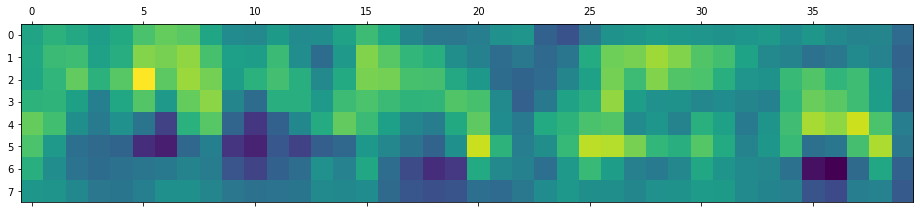

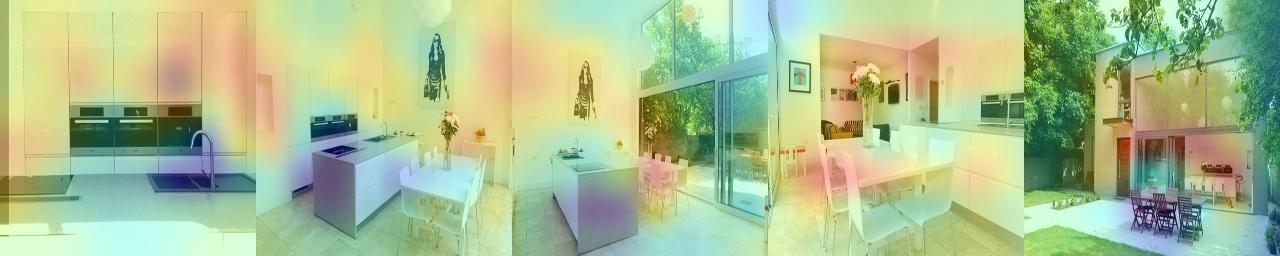

Predicted:  72.076164
True:  184.0


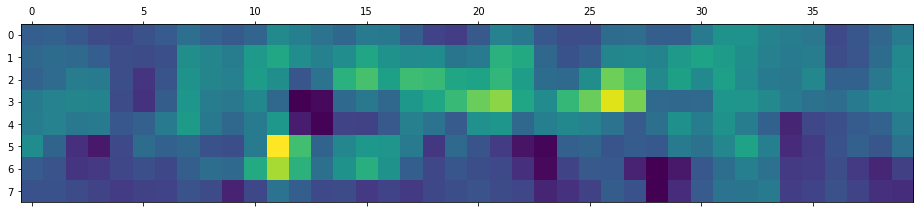

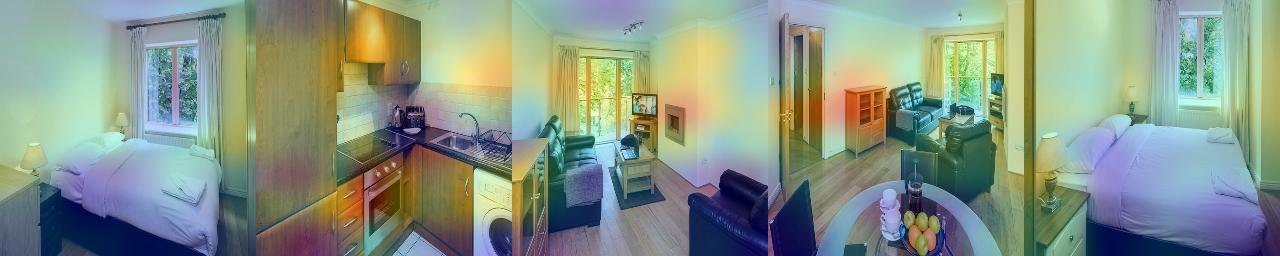

Predicted:  54.99486
True:  250.00002


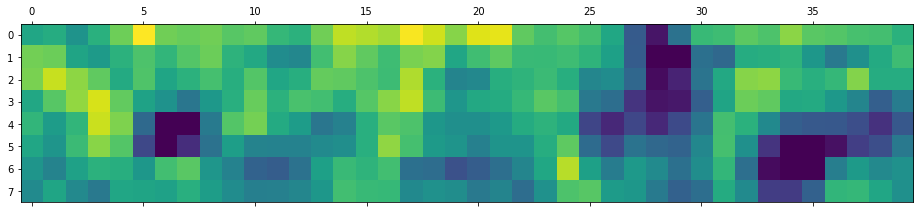

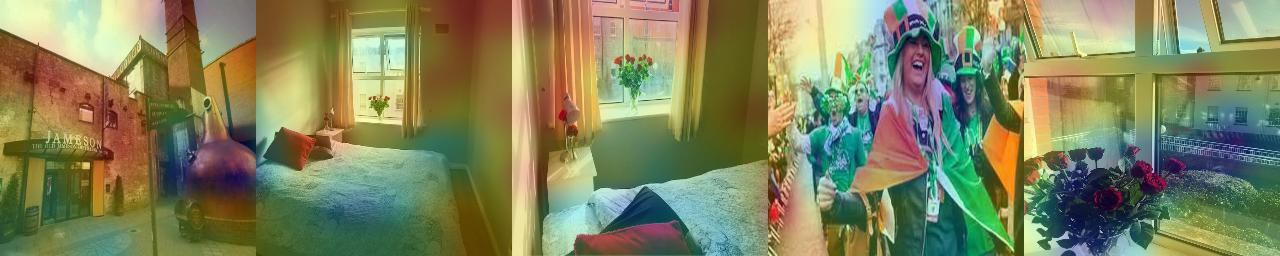

Predicted:  43.013138
True:  25.0


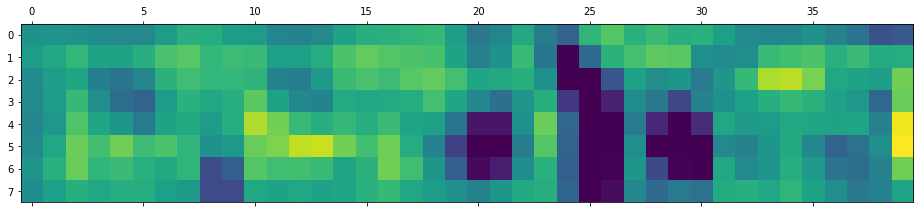

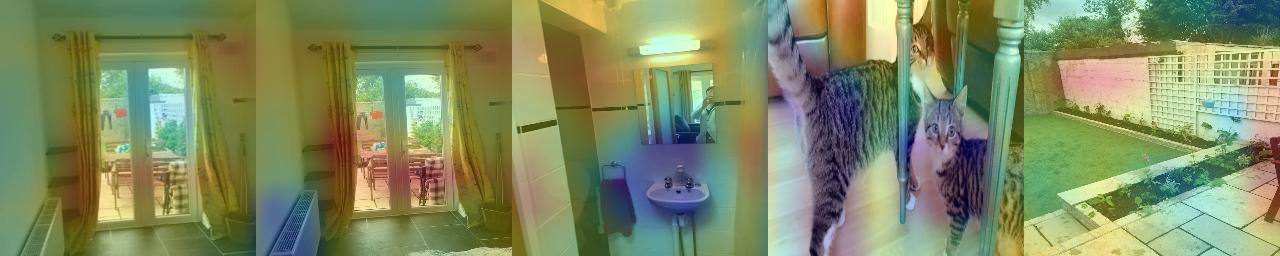

Predicted:  56.952892
True:  120.000015


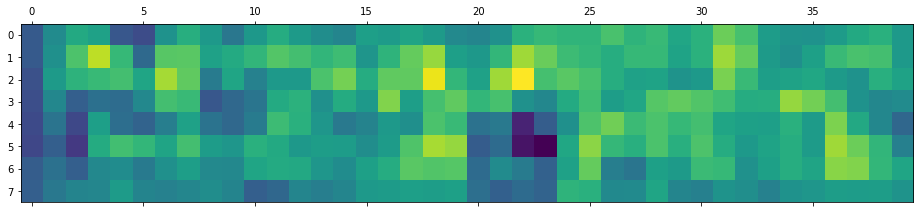

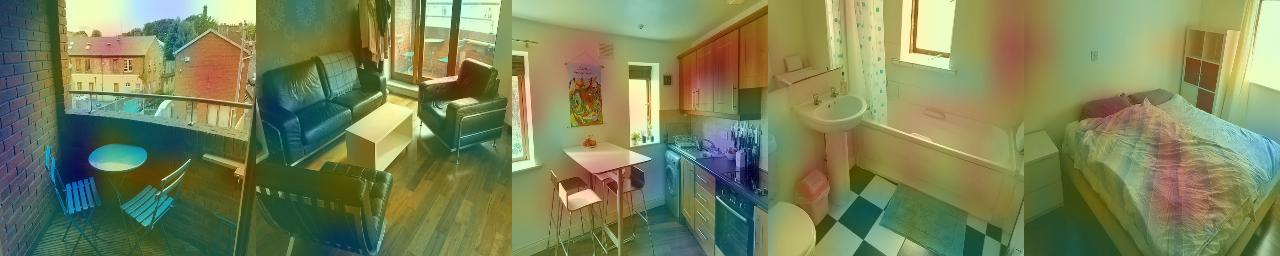

Predicted:  59.375595
True:  80.00001


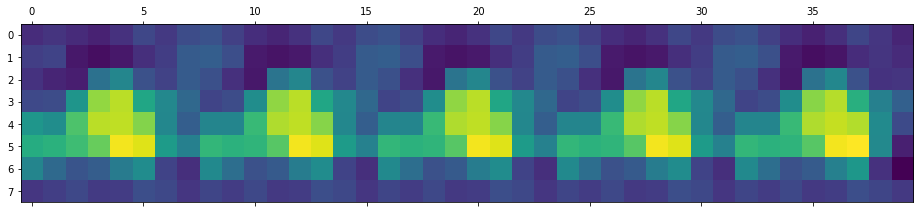

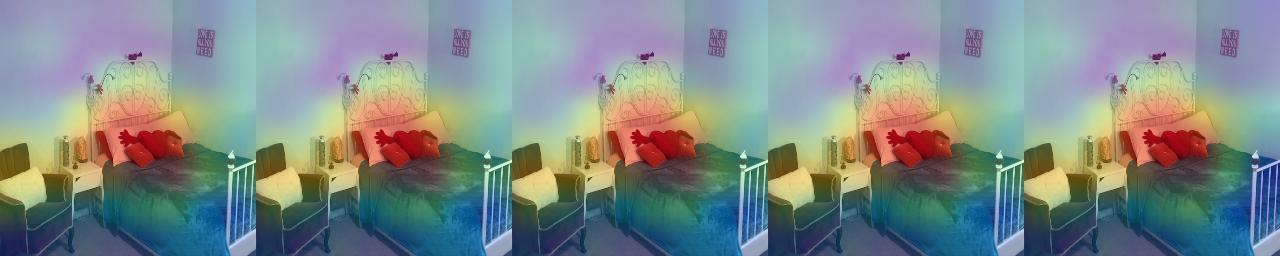

Predicted:  70.38211
True:  120.000015


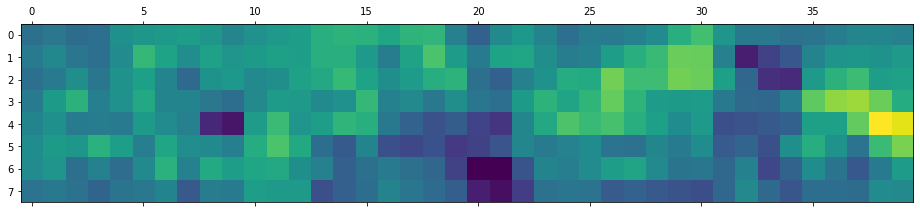

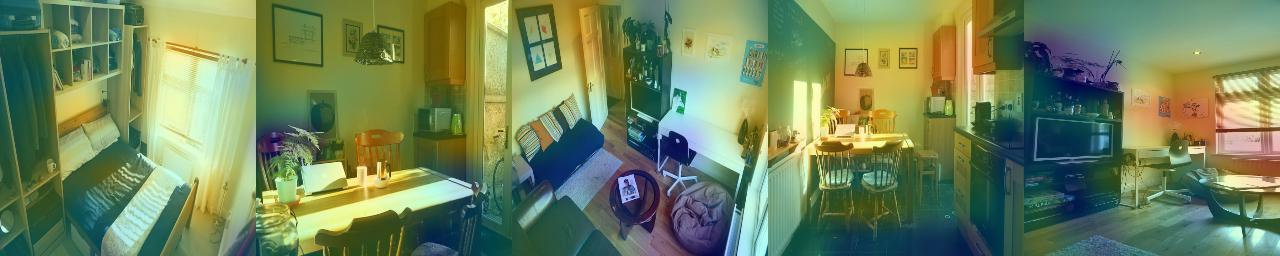

In [58]:
for i in range(b):
  img_array = img_arrays[i]
  img_size = (w,h)
  img_array = preprocess_input(np.expand_dims(img_array, axis=0))

  # Print what the top predicted class is
  preds = model.predict(img_array)
  print("Predicted: ", np.exp(np.squeeze(preds)))
  print("True: ", np.exp(np.squeeze(prices[i])))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Display heatmap
  plt.matshow(heatmap)
  plt.show()

  img_array = img_arrays[i]
  img_array = img_array.numpy().astype(float)

  save_and_display_gradcam(img_array, heatmap)


55.986958


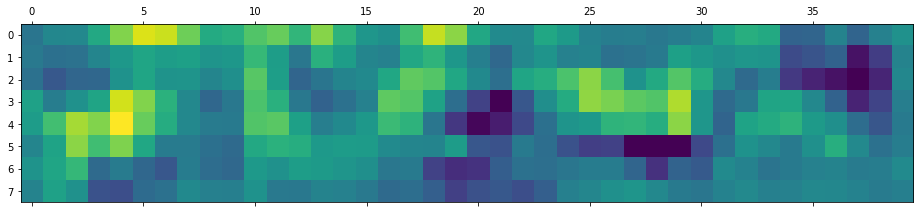

In [49]:
img_array = img_array[1]
img_size = (w,h)
img_array = preprocess_input(np.expand_dims(img_array, axis=0))

# Print what the top predicted class is
preds = model.predict(img_array)
print(np.exp(np.squeeze(preds)))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [29]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

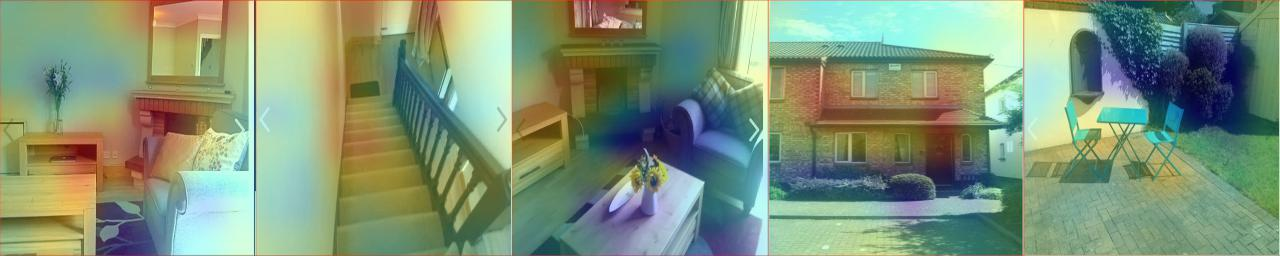

In [41]:
for i in test_dataset.take(1):
  img_array = i[0]["input_1"]
img_array = img_array[1]

img_array = img_array.numpy().astype(float)

save_and_display_gradcam(img_array, heatmap)

In [36]:
for i in test_dataset.take(1):
  img_array = i[0]["input_1"]
img_array = img_array[0]

img_array = img_array.numpy().astype(float)